## Импорт необходимых библиотек

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp
import torchvision.models as models

## Конфигурация PyTorch

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [14]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256

## Класс, описывающий датасет

In [15]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [16]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])


## Загрузка датасета

In [17]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [18]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [19]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Функция по расчету необходимых метрик

In [20]:
# Метрики
def calculate_metrics(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()
    masks = (masks > 0.5).float()
    batch_ious, batch_dices = [], []

    for i in range(outputs.shape[0]):
        output = outputs[i]
        mask = masks[i]
        intersection = (output * mask).sum()
        union = (output + mask).sum() - intersection
        total = output.sum() + mask.sum()
        iou = (intersection / union).item() if union != 0 else float(output.sum() == 0 and mask.sum() == 0)
        dice = (2. * intersection / total).item() if total != 0 else 1.0
        batch_ious.append(iou)
        batch_dices.append(dice)

    return np.mean(batch_ious), np.mean(batch_dices)

## LinkNet

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, middle_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class LinkNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=3):
        super(LinkNet, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.in_block = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.encoder1 = resnet.layer1  # 256
        self.encoder2 = resnet.layer2  # 512
        self.encoder3 = resnet.layer3  # 1024
        self.encoder4 = resnet.layer4  # 2048

        self.decoder4 = DecoderBlock(2048, 512, 1024)
        self.decoder3 = DecoderBlock(1024, 256, 512)
        self.decoder2 = DecoderBlock(512, 128, 256)
        self.decoder1 = DecoderBlock(256, 64, 64)
        self.final_deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.in_block(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        out = self.final_deconv(d1)
        return out

## Обучение модели

In [22]:
# Создаем модель с дополнительными слоями
print(device)

model = LinkNet(num_classes=1, in_channels=3).to(device)

modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "Linknet.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

cuda
Epoch 1/100
Train Loss: 0.4790 | Test Loss: 0.4673
IoU: 0.7704 | Dice: 0.7704
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7704
Epoch 2/100
Train Loss: 0.4532 | Test Loss: 0.5396
IoU: 0.7707 | Dice: 0.7707
------------------------
Best modified_model saved at epoch 2 with IoU: 0.7707
Epoch 3/100
Train Loss: 0.4475 | Test Loss: 0.5380
IoU: 0.7186 | Dice: 0.7293
------------------------
Epoch 4/100
Train Loss: 0.4416 | Test Loss: 0.4677
IoU: 0.7331 | Dice: 0.7356
------------------------
Epoch 5/100
Train Loss: 0.4401 | Test Loss: 0.4669
IoU: 0.7389 | Dice: 0.7396
------------------------
Epoch 6/100
Train Loss: 0.4373 | Test Loss: 0.4430
IoU: 0.7710 | Dice: 0.7710
------------------------
Best modified_model saved at epoch 6 with IoU: 0.7710
Epoch 7/100
Train Loss: 0.4370 | Test Loss: 0.4775
IoU: 0.7710 | Dice: 0.7710
------------------------
Epoch 8/100
Train Loss: 0.4356 | Test Loss: 0.4553
IoU: 0.7536 | Dice: 0.7539
------------------------
Epoch 9/1

## Метрики

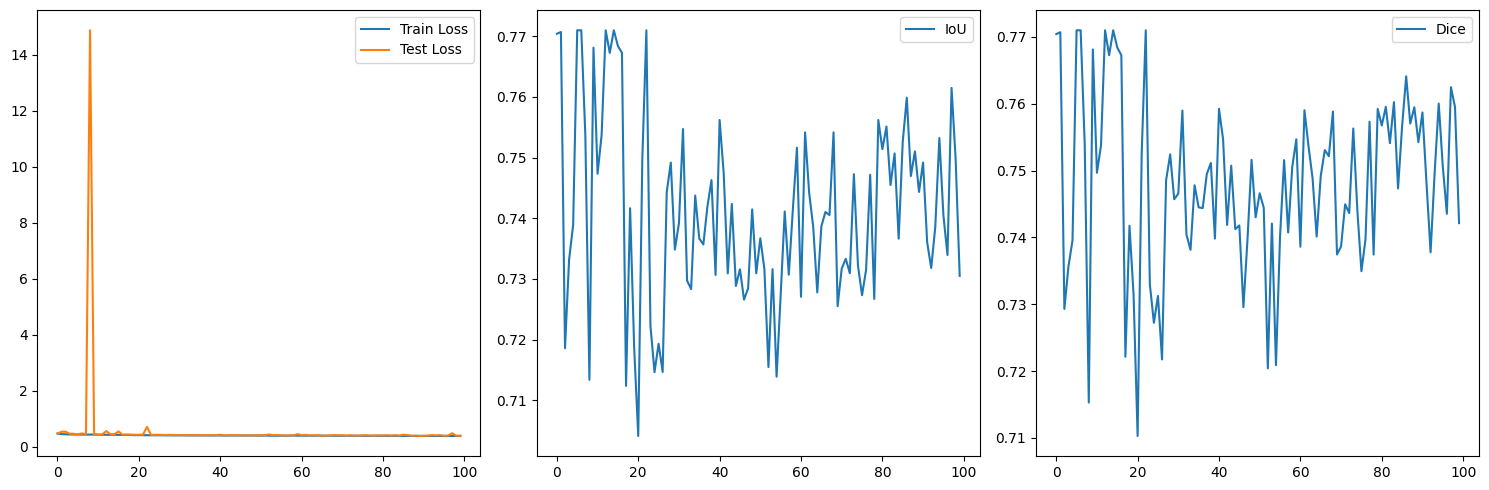

In [23]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
torch.save(model.state_dict(), "Linknet.pth")